# SHAP Values for Multi-Output Regression Models

Author: (https://github.com/coryroyce)

Date updated: 3/4/2021

## Create Multi-Output Regression Model

### Create Data

Import required packages

In [41]:
import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from sklearn.datasets import make_regression

Create a custom function that generates the multi-output regression data.
Note: Creating 5 outputs/targets/labels for this example, but the method easily extends to any number or outputs.

In [42]:
def get_dataset():
    # Create sample data with sklearn make_regression function
    X, y = make_regression(n_samples=1000, n_features=10, n_informative=7, n_targets=5, random_state=0)

    # Convert the data into Pandas Dataframes for easier maniplution and keeping stored column names
    # Create feature column names
    feature_cols = [
        "feature_01",
        "feature_02",
        "feature_03",
        "feature_04",
        "feature_05",
        "feature_06",
        "feature_07",
        "feature_08",
        "feature_09",
        "feature_10",
    ]

    df_features = pd.DataFrame(data=X, columns=feature_cols)

    # Create lable column names and dataframe
    label_cols = ["labels_01", "labels_02", "labels_03", "labels_04", "labels_05"]

    df_labels = pd.DataFrame(data=y, columns=label_cols)

    return df_features, df_labels

### Create Model

Create a Tensorflow/Keras Sequential model.

In [43]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer="he_uniform", activation="relu"))
    model.add(Dense(n_outputs, kernel_initializer="he_uniform"))
    model.compile(loss="mae", optimizer="adam")
    return model

### Train Model

Create the dataset with the function defined above.

In [44]:
# Create the datasets
X, y = get_dataset()

# Get the number of inputs and outputs from the dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]

Load the model with function defined above.

In [45]:
model = get_model(n_inputs, n_outputs)

C:\Users\gyanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train the model

In [46]:
model.fit(X, y, verbose=0, epochs=100)

Get model evaluation metrics to confirm training went well.

In [47]:
model.evaluate(x=X, y=y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.2859 


14.285872459411621

### Model Prediction

Manual data can be entered but in this case, just us an arbitrary index form the feature/X data.

In [48]:
model.predict(X.iloc[0:1, :])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[  18.273066,  -60.145073,  -66.11081 ,  -75.43779 , -110.97627 ]],
      dtype=float32)

## Get SHAP Values and Plots

Apply Shapley vaules to the model.

In [49]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

Here we take the Keras model trained above and explain why it makes different predictions on individual samples.

Set the explainer using the Kernel Explainer (Model agnostic explainer method form SHAP).

In [50]:
explainer = shap.KernelExplainer(model=model.predict, data=X.head(50), link="identity")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Get the Shapley value for a single example.

In [51]:
# Set the index of the specific example to explain
X_idx = 0

shap_value_single = explainer.shap_values(X=X.iloc[X_idx : X_idx + 1, :], nsamples=100)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


Display the details of the single example

In [52]:
X.iloc[X_idx : X_idx + 1, :]

,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10
0,-0.093555,0.417854,-1.655827,-2.048833,-0.258209,-0.989744,-0.154596,-0.338294,1.503827,-0.514878


Choose the label/output/target to run individual explanations on:

Note: The dropdown menu can easily be replaced by manually setting the index on the label to explain. 

In [53]:
import ipywidgets as widgets
import numpy as np

In [54]:
# Create the list of all labels for the drop down list
list_of_labels = y.columns.to_list()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels, value=0, description="Select Label:")

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Label:', options=(('labels_01', 0), ('labels_02', 1), ('labels_03', 2), ('labels_…

Plot the force plot for a single example and a single label/output/target

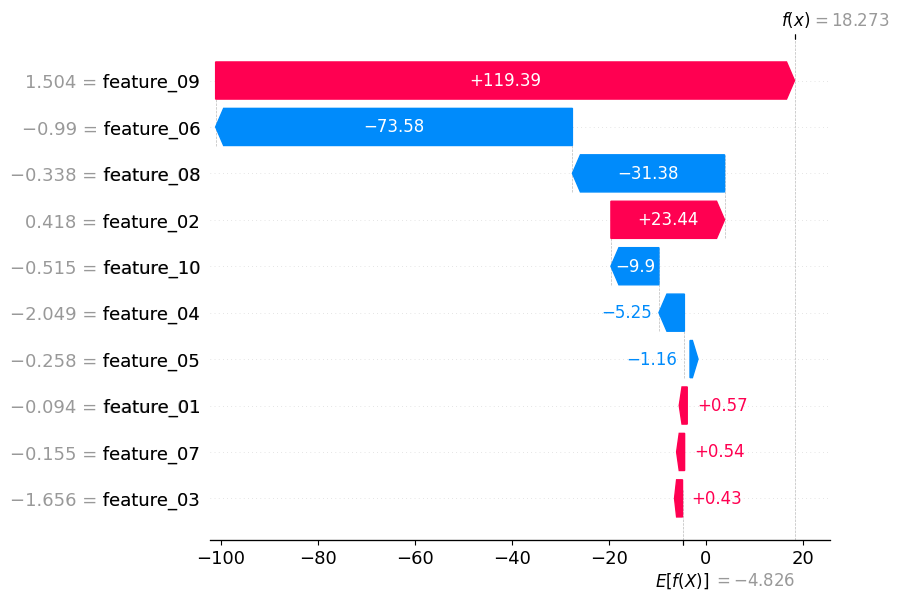

In [55]:
label = current_label.value
shap.plots.waterfall(
    shap.Explanation(
        values=shap_value_single[0, :, label],
        base_values=explainer.expected_value[label],
        data=X.iloc[X_idx],
        feature_names=X.columns,
    )
)


Create the summary plot for a specific output/label/target.

In [56]:
# Note: We are limiting to the first 50 training examples since it takes time to calculate the full number of sampels
shap_values = explainer.shap_values(X=X.iloc[0:50, :], nsamples=100)

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

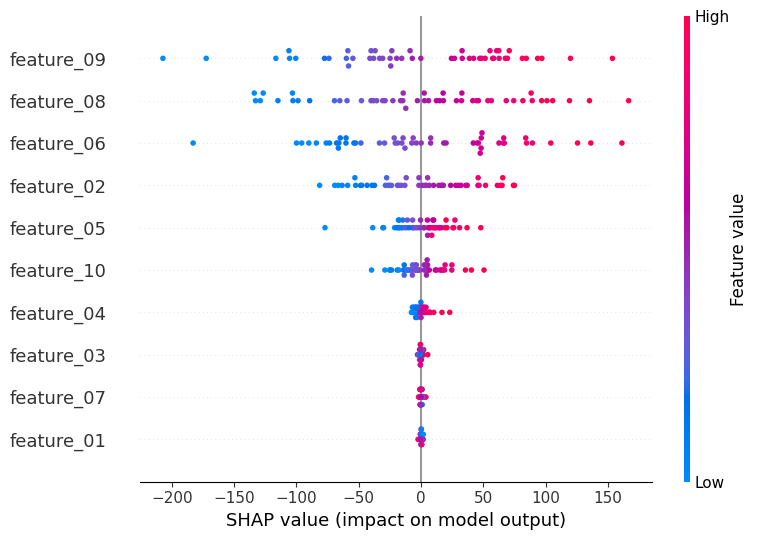

In [57]:
# print the JS visualization code to the notebook
shap.initjs()

label = current_label.value

shap.summary_plot(
    shap_values=shap_values[:50, :, label],  # 👈 samples × features
    features=X.iloc[:50, :],
    feature_names=X.columns
)

Summary Plot Notes:

Based on the above summary plot we can see that Features 01, 03, and 07 are the features that have no influence on the model and could be dropped (Note that in the data setup we chose 10 features and only 7 of them had a meaningful relationship with the labels/targets). This is the big advantage of SHAP since without this we would not have much insight into which features are actually influencing our model.

The above setup with the dropdown menu allows us to choose the individual labels to explore in more detail. 

Force Plot for the first 50 individual examples.

## Reference

Multi-output regression model format/build was largely based on [Deep Learning Models for Multi-Output Regression](https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/)